# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Load the Data/Filtering for Chosen Zipcodes

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
from pandas import Series
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas import Series
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


%matplotlib inline
plt.style.use('ggplot')
%matplotlib inline 


In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [4]:
df['RegionName'].value_counts().sum()

14723

In [5]:
df['City'].value_counts()

New York         114
Los Angeles       95
Houston           88
San Antonio       48
Washington        45
Chicago           41
Springfield       40
Austin            40
Las Vegas         38
Columbus          38
Philadelphia      38
Phoenix           37
Kansas City       37
Dallas            35
Portland          34
San Diego         33
Louisville        32
Oklahoma City     30
Denver            30
Omaha             30
Arlington         29
Jacksonville      28
San Jose          27
Richmond          27
Indianapolis      26
Fort Worth        26
Lincoln           25
Franklin          25
Charlotte         25
Lexington         25
                ... 
Kaukauna           1
Paragould          1
Madbury            1
Sandia Park        1
Ventress           1
San Lorenzo        1
La Palma           1
Galway             1
Adams Center       1
Tillson            1
Alvord             1
North Babylon      1
West Orange        1
Ogunquit           1
Port Deposit       1
Zionville          1
Richmond Hill

We have 14,723 zipcodes in 7554 cities. Let's narrow this down and find the top 5 zipcodes in Austin. It is the second fastest growing city in the US

In [6]:
df = df.loc[df['City'] == 'Austin']
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
66,92617,78704,Austin,TX,Austin,Travis,67,221300.0,221100.0,221000.0,...,530100,532400,534200,536200,538200,539800,540200,542300,547100,550900
98,92654,78745,Austin,TX,Austin,Travis,99,135000.0,134200.0,133800.0,...,286300,286900,287500,288700,289800,290500,291300,292600,294000,294700
422,92667,78758,Austin,TX,Austin,Travis,423,129000.0,128300.0,127500.0,...,250000,248400,247500,247400,247900,250500,255100,260100,266000,270400
432,92651,78741,Austin,TX,Austin,Travis,433,93800.0,93600.0,93500.0,...,228000,226700,227600,230200,234100,238300,241000,243600,247400,250400
502,92662,78753,Austin,TX,Austin,Travis,503,111300.0,110600.0,109900.0,...,222600,223200,223600,223100,223100,225000,227100,228700,231500,233400


In [7]:
#making sure we are only identifying zipcodes in the Austin, TX
df = df.loc[df['State'] == 'TX']
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
66,92617,78704,Austin,TX,Austin,Travis,67,221300.0,221100.0,221000.0,...,530100,532400,534200,536200,538200,539800,540200,542300,547100,550900
98,92654,78745,Austin,TX,Austin,Travis,99,135000.0,134200.0,133800.0,...,286300,286900,287500,288700,289800,290500,291300,292600,294000,294700
422,92667,78758,Austin,TX,Austin,Travis,423,129000.0,128300.0,127500.0,...,250000,248400,247500,247400,247900,250500,255100,260100,266000,270400
432,92651,78741,Austin,TX,Austin,Travis,433,93800.0,93600.0,93500.0,...,228000,226700,227600,230200,234100,238300,241000,243600,247400,250400
502,92662,78753,Austin,TX,Austin,Travis,503,111300.0,110600.0,109900.0,...,222600,223200,223600,223100,223100,225000,227100,228700,231500,233400


In [8]:
#checking out for null values
df.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
1996-04       0
1996-05       0
1996-06       0
1996-07       0
1996-08       0
1996-09       0
1996-10       0
1996-11       0
1996-12       0
1997-01       0
1997-02       0
1997-03       0
1997-04       0
1997-05       0
1997-06       0
1997-07       0
1997-08       0
1997-09       0
1997-10       0
1997-11       0
1997-12       0
1998-01       0
1998-02       0
             ..
2015-11       0
2015-12       0
2016-01       0
2016-02       0
2016-03       0
2016-04       0
2016-05       0
2016-06       0
2016-07       0
2016-08       0
2016-09       0
2016-10       0
2016-11       0
2016-12       0
2017-01       0
2017-02       0
2017-03       0
2017-04       0
2017-05       0
2017-06       0
2017-07       0
2017-08       0
2017-09       0
2017-10       0
2017-11       0
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int6

No apparent missing values from Texas pricing data

Now we have a clean sheet showing all of the zipcodes in Austin, with their associated pricing over time. Let's narrow this down to our top 5 locations. 

In [9]:
#Adding ROI column to our data frame 
df['ROI'] = ((df['2018-04']-df['1996-04'])/df['1996-04'])
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
66,92617,78704,Austin,TX,Austin,Travis,67,221300.0,221100.0,221000.0,...,532400,534200,536200,538200,539800,540200,542300,547100,550900,1.489381
98,92654,78745,Austin,TX,Austin,Travis,99,135000.0,134200.0,133800.0,...,286900,287500,288700,289800,290500,291300,292600,294000,294700,1.182963
422,92667,78758,Austin,TX,Austin,Travis,423,129000.0,128300.0,127500.0,...,248400,247500,247400,247900,250500,255100,260100,266000,270400,1.096124
432,92651,78741,Austin,TX,Austin,Travis,433,93800.0,93600.0,93500.0,...,226700,227600,230200,234100,238300,241000,243600,247400,250400,1.669510
502,92662,78753,Austin,TX,Austin,Travis,503,111300.0,110600.0,109900.0,...,223200,223600,223100,223100,225000,227100,228700,231500,233400,1.097035


In [10]:
#Adding risk column to our data (Std/mean)
df['std'] = df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)
df['mean'] = df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)
df['Risk'] = df['std']/df['mean']
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI,std,mean,Risk
66,92617,78704,Austin,TX,Austin,Travis,67,221300.0,221100.0,221000.0,...,538200,539800,540200,542300,547100,550900,1.489381,80041.992067,353229.433962,0.226601
98,92654,78745,Austin,TX,Austin,Travis,99,135000.0,134200.0,133800.0,...,289800,290500,291300,292600,294000,294700,1.182963,41733.948394,172890.566038,0.241389
422,92667,78758,Austin,TX,Austin,Travis,423,129000.0,128300.0,127500.0,...,247900,250500,255100,260100,266000,270400,1.096124,34194.863952,149549.056604,0.228653
432,92651,78741,Austin,TX,Austin,Travis,433,93800.0,93600.0,93500.0,...,234100,238300,241000,243600,247400,250400,1.669510,34946.752103,140678.490566,0.248416
502,92662,78753,Austin,TX,Austin,Travis,503,111300.0,110600.0,109900.0,...,223100,225000,227100,228700,231500,233400,1.097035,28415.529319,138712.452830,0.204852


To choose the top 5 zipcodes we want to consider those with the highest ROI and lowest Risk 

In [11]:
df_risk = df.Risk.quantile(.5)
df = df[df['Risk'] < df_risk].sort_values('ROI',axis=0,ascending=False)[:5]
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI,std,mean,Risk
3428,92639,78728,Austin,TX,Austin,Travis,3429,136600.0,136500.0,136400.0,...,260300,260600,260700,262300,265000,266500,0.950952,32469.492710,173165.283019,0.187506
6302,92635,78724,Austin,TX,Austin,Travis,6303,97500.0,96900.0,96200.0,...,183800,185300,186400,187900,189100,189300,0.941538,21933.749961,119890.943396,0.182948
3581,92655,78746,Austin,TX,Austin,Travis,3582,493300.0,496600.0,500100.0,...,905500,909000,912600,917200,921200,918700,0.862356,111516.379240,620464.150943,0.179731
6629,92648,78737,Austin,TX,Austin,Travis,6630,247300.0,247600.0,247800.0,...,436900,438300,439200,442400,447400,450400,0.821270,50466.062540,312844.905660,0.161313
2649,92628,78717,Austin,TX,Austin,Travis,2650,200800.0,200400.0,200500.0,...,354600,355100,356600,359500,362300,363600,0.810757,38230.738664,254540.000000,0.150195


# Reshape from Wide to Long Format

In [12]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank','ROI','std','mean','Risk'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [13]:
df = melt_data(df)
display(df.head())
df.info()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,ROI,std,mean,Risk,Month,MeanValue
0,92639,78728,Austin,TX,Austin,Travis,3429,0.950952,32469.492710,173165.283019,0.187506,1996-04-01,136600.0
1,92635,78724,Austin,TX,Austin,Travis,6303,0.941538,21933.749961,119890.943396,0.182948,1996-04-01,97500.0
2,92655,78746,Austin,TX,Austin,Travis,3582,0.862356,111516.379240,620464.150943,0.179731,1996-04-01,493300.0
3,92648,78737,Austin,TX,Austin,Travis,6630,0.821270,50466.062540,312844.905660,0.161313,1996-04-01,247300.0
4,92628,78717,Austin,TX,Austin,Travis,2650,0.810757,38230.738664,254540.000000,0.150195,1996-04-01,200800.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 13 columns):
RegionID      1325 non-null int64
RegionName    1325 non-null int64
City          1325 non-null object
State         1325 non-null object
Metro         1325 non-null object
CountyName    1325 non-null object
SizeRank      1325 non-null int64
ROI           1325 non-null float64
std           1325 non-null float64
mean          1325 non-null float64
Risk          1325 non-null float64
Month         1325 non-null datetime64[ns]
MeanValue     1325 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(4)
memory usage: 144.9+ KB


# Data Preprocessing

In [14]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [15]:
df.set_index('Month', inplace = True)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,ROI,std,mean,Risk,MeanValue
Month,,,,,,,,,,,,
1996-04-01,92639,78728,Austin,TX,Austin,Travis,3429,0.950952,32469.492710,173165.283019,0.187506,136600.0
1996-04-01,92635,78724,Austin,TX,Austin,Travis,6303,0.941538,21933.749961,119890.943396,0.182948,97500.0
1996-04-01,92655,78746,Austin,TX,Austin,Travis,3582,0.862356,111516.379240,620464.150943,0.179731,493300.0
1996-04-01,92648,78737,Austin,TX,Austin,Travis,6630,0.821270,50466.062540,312844.905660,0.161313,247300.0
1996-04-01,92628,78717,Austin,TX,Austin,Travis,2650,0.810757,38230.738664,254540.000000,0.150195,200800.0


In [16]:
#drop unneccary columns
df.drop(['RegionID','City','State','Metro','CountyName','SizeRank','std','mean',"Risk","ROI"], axis=1, inplace=True)
df.head()

,RegionName,MeanValue
Month,,
1996-04-01,78728,136600.0
1996-04-01,78724,97500.0
1996-04-01,78746,493300.0
1996-04-01,78737,247300.0
1996-04-01,78717,200800.0


# EDA/Visualization

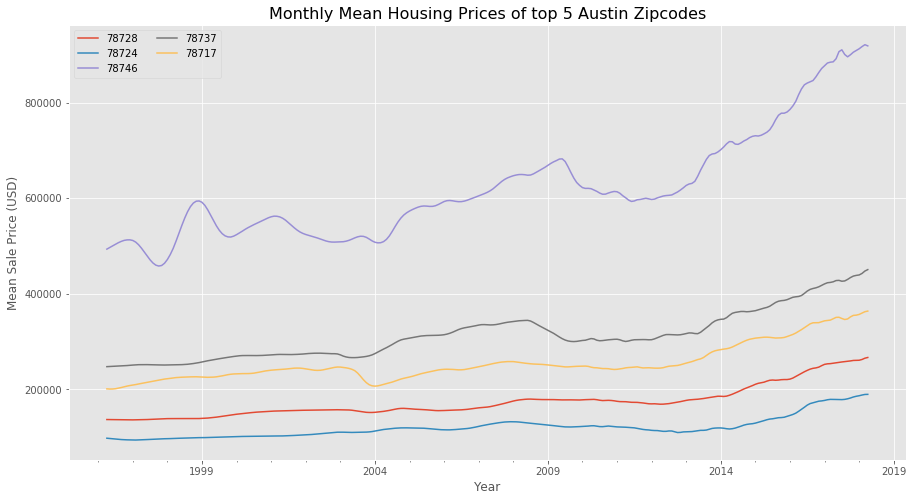

In [17]:
for zipcode in df.RegionName.unique():
    temp_df = df[df.RegionName == zipcode]
    temp_df['MeanValue'].plot(figsize=(15,8), label=zipcode)
plt.legend(ncol=2)
plt.xlabel("Year")
plt.ylabel("Mean Sale Price (USD)")
plt.title("Monthly Mean Housing Prices of top 5 Austin Zipcodes", fontsize=16);

There seems to be upward trends for 4 of the zip codes, and an exponential trend for 1 of teh zip codes. Let's examine the exponential and then examine of the other 4 upward trending.

In [18]:
df1 = df.loc[df['RegionName'] == 78724]
df1.head()

,RegionName,MeanValue
Month,,
1996-04-01,78724,97500.0
1996-05-01,78724,96900.0
1996-06-01,78724,96200.0
1996-07-01,78724,95600.0
1996-08-01,78724,95100.0


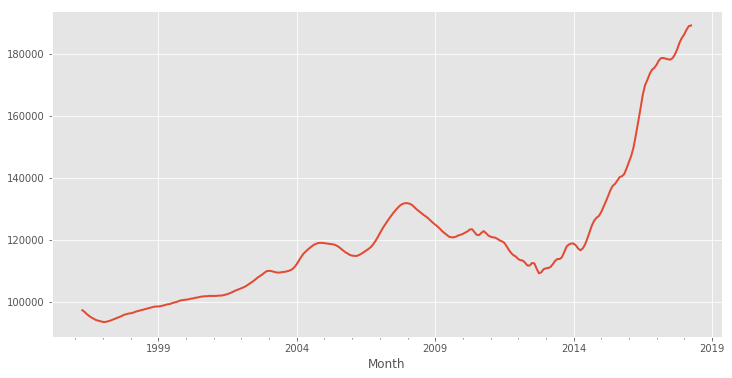

In [19]:
df1['MeanValue'].plot(figsize=(12,6), linewidth=2, fontsize=10);

### Testing for Stationarity


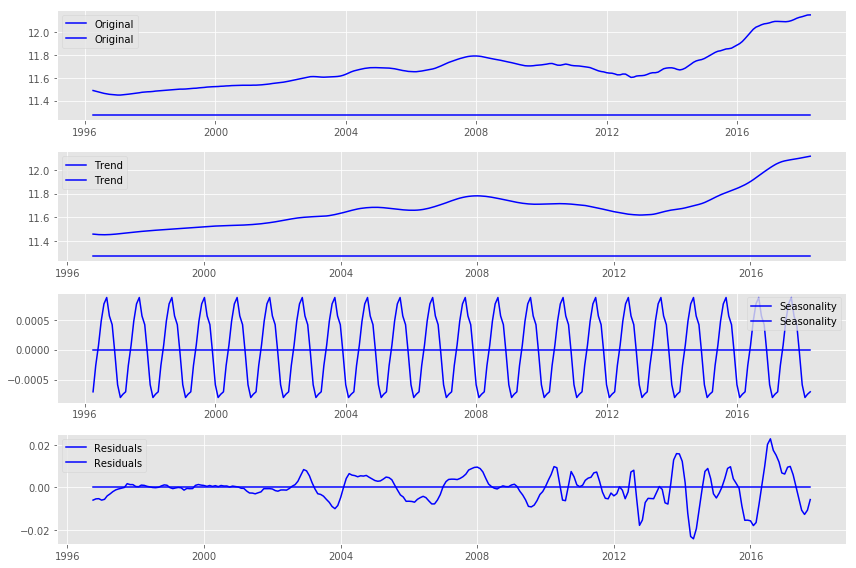

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(df1))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(df1), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

In [21]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 8, center = False).mean()
    rolstd = TS.rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['MeanValue']) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

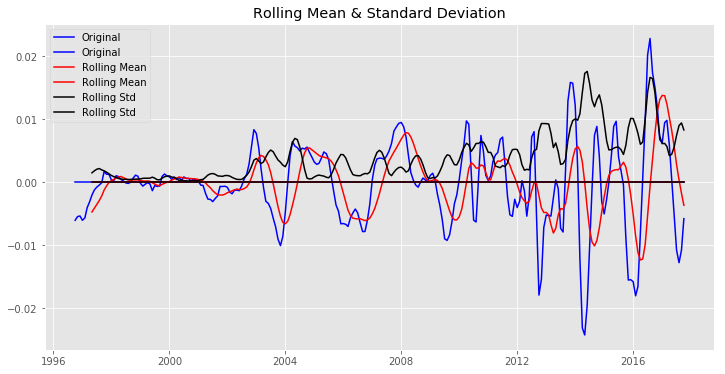

Results of Dickey-Fuller Test:
Test Statistic                  -4.409563
p-value                          0.000285
#Lags Used                      16.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


In [22]:
# Drop NaN values from residuals.
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(ts_log_decompose)

Test Statistic is less than the critical value indicating this is stationary! Will use ARIMA

# SARIMA

Used to fit time series data to better understand and forecast future points in the time series.Our model is a non-stationary series with significant dependence among values, and seasonality. In this case we can use a seasonal arima or SARIMA model.


### A: Parameter Selection

We first find the values of ARIMA(p,d,q)(P,D,Q)s that produce the desired output to fit the model correctly

In [24]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

Next step we will measure the relative quality of statistical models using AIC. We want to find a balance where the model uses the least features to achieve the best goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [196]:
def best_pdq(df):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print (ans_df.loc[ans_df['aic'].idxmin()])

In [197]:
best_pdq(df1['MeanValue'])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6934.828996874648
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6458.7724477883785
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5323.71420114268
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5081.828358460254
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5276.138972135021
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5254.531587651155
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5000.375356448147
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4982.439801983937
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6718.661548909175
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6369.152107385007
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5276.842644053271
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =6807.740934810369
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6775.186202440274
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6710.472790025322
ARIMA (0, 0, 1) x (1

Now we can select the AIC with the lowest score to move forward with for our SARIMAX model which is seen above

In [199]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df1['MeanValue'], 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8218      0.022     37.552      0.000       0.779       0.865
ma.L1          0.7169      0.033     21.576      0.000       0.652       0.782
ma.S.L12      -0.9287      0.052    -17.858      0.000      -1.031      -0.827
sigma2      9.608e+04   7912.596     12.143      0.000    8.06e+04    1.12e+05


Since all of our P values are below the coeffecient threshold we know that they are all important have have impact

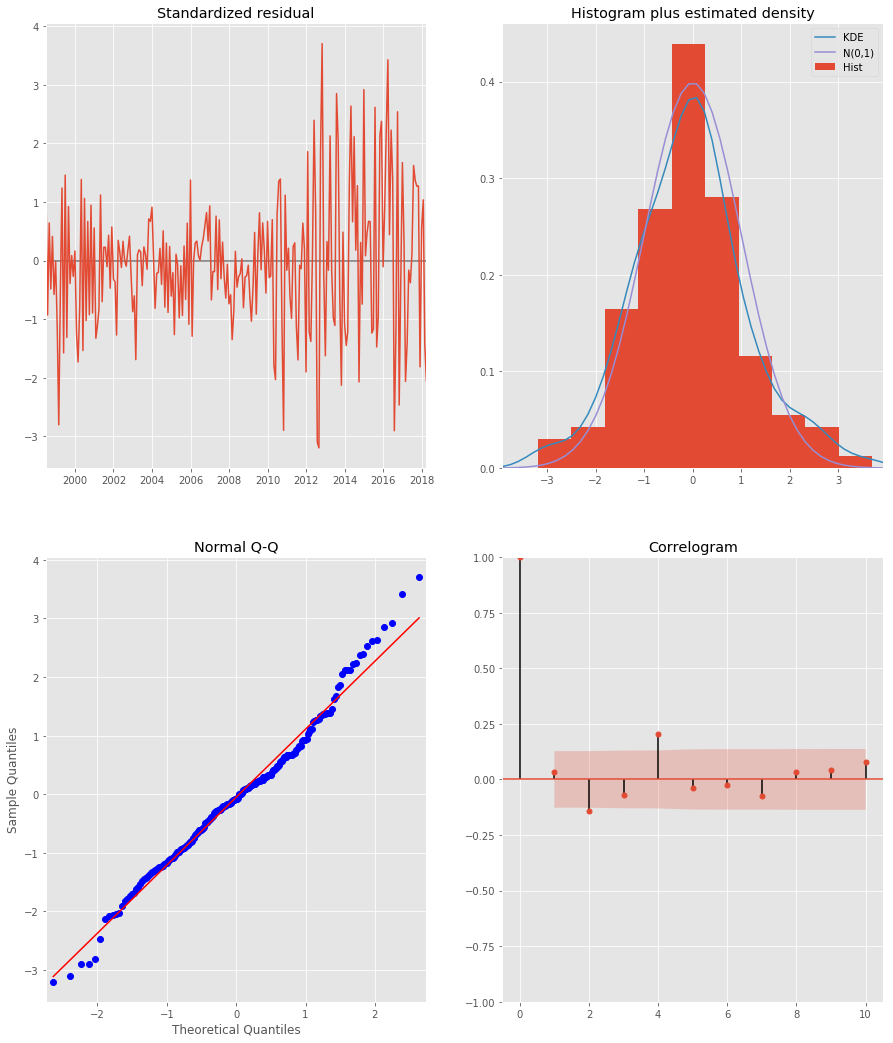

In [200]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In reviewing the above graphs we make note of the following:

Standard residuals: Seems to be White Noise. It appears our graph is uncorrelated which means we have a sound model. The only place where there seems to be a trend is after the 2008 housing crisis which we will take into account in predictions
    
Histogram: The residuals seem to be normally distributed 
    
QQ plot: Seems to be a fairly accurate linear trend indicating normal distribution of residuals
    
Correlogram: Shows that the time series residuals have low correlation with lagged versions of itself.
    

We are safe to move forward and conclude that our model has limited correlations and provides a satisfactory fit to help forecast future values. The only place there appears to be a trend is after 2008 housing crisis, for this purpose we will start to make predictions in 2010

### B: Validating the Model

Now let's compare predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.

In [201]:
# Get predictions starting from 2010-01-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_conf = pred.conf_int()

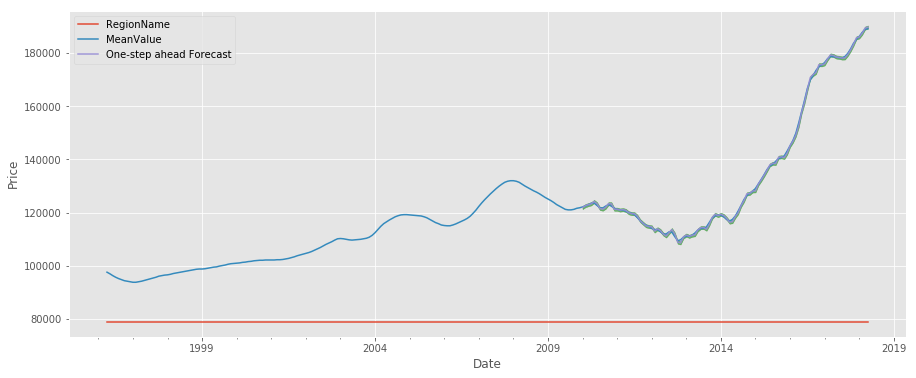

In [202]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df1['1996':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

The forecasts align with the true values as seen above, with overall increase trend.

### C: Producing and Visualizing Forecasts

We can use the code below to plot the time series and forecasts of its future values.

In [203]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

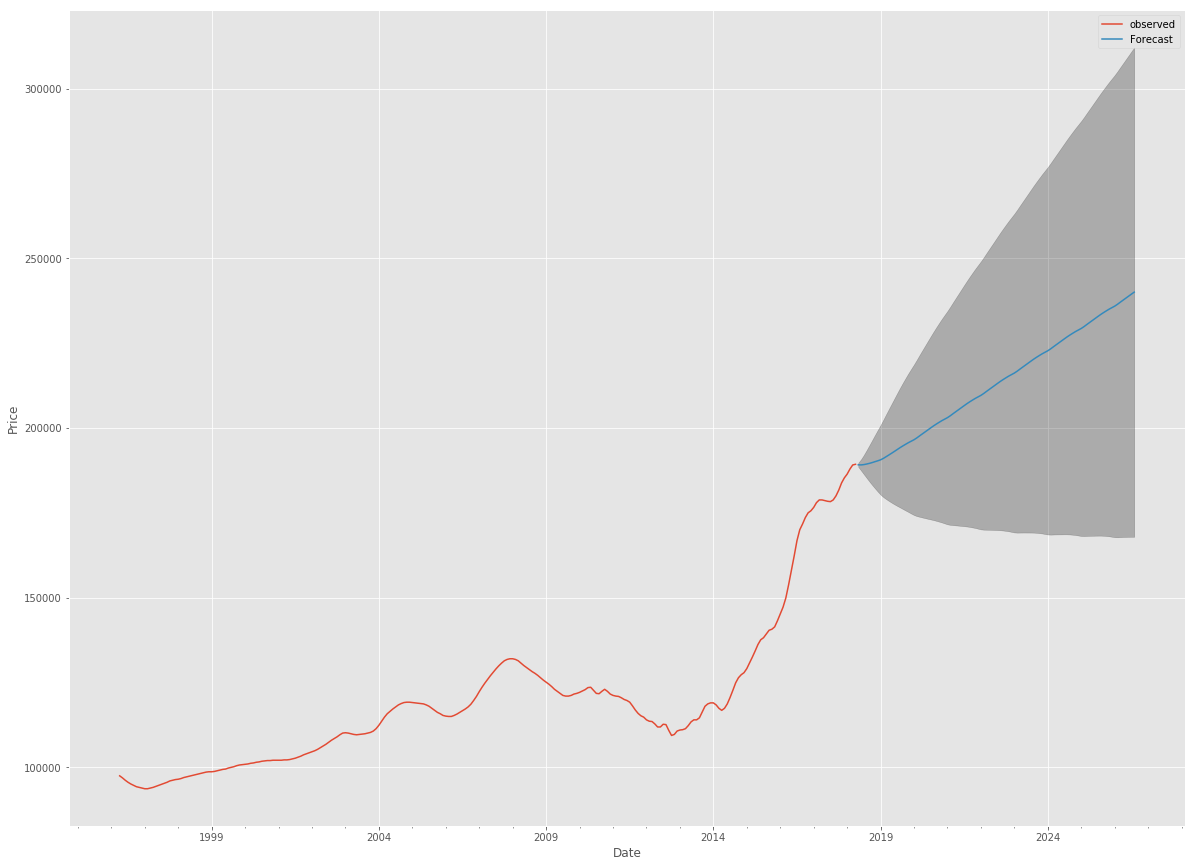

In [204]:
ax = df1['MeanValue'].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

### Let's Take a look at the remaining zipcodes! 

In [115]:
df2 = df.loc[df['RegionName'] == 78728]
df3 = df.loc[df['RegionName'] == 78746]
df4 = df.loc[df['RegionName'] == 78737]
df5 = df.loc[df['RegionName'] == 78717]
df_zips = [df2,df3,df4,df5]

In [198]:
best_pdq(df2['MeanValue'])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7129.423832099113
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6644.793889372415
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5373.8486107585095
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5130.3094930348725
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5266.832034996407
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5248.380404755096
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5010.392322179574
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4993.914918218829
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6912.4666847849585
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6554.124407147536
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5349.829746310373
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =7133.355056044704
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6584.827526915464
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6534.714053794871
ARIMA (0, 0, 1) x

In [210]:
# Plug the optimal parameter values into a new SARIMAX model
def zip_arima_fit(df,pdq,pdqs):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                            order=pdq, 
                                            seasonal_order=pdqs, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

# Fit the model and print results
    output = ARIMA_MODEL.fit()

    print(output.summary().tables[1])
    
    output.plot_diagnostics(figsize=(15, 18))
    plt.show()
    
    pred = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
    pred_conf = pred.conf_int()
    
    rcParams['figure.figsize'] = 15, 6

# Plot observed values
    ax = df['1996':].plot(label='observed')

# Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()

    plt.show()
    
# Get forecast 500 steps ahead in future
    prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    
    ax = df.plot(label='observed', figsize=(20, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=0.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    plt.legend()
    plt.show()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7975      0.029     27.340      0.000       0.740       0.855
ma.L1          0.6815      0.029     23.248      0.000       0.624       0.739
ma.S.L12      -0.7354      0.038    -19.318      0.000      -0.810      -0.661
sigma2      1.067e+05   6420.787     16.625      0.000    9.42e+04    1.19e+05


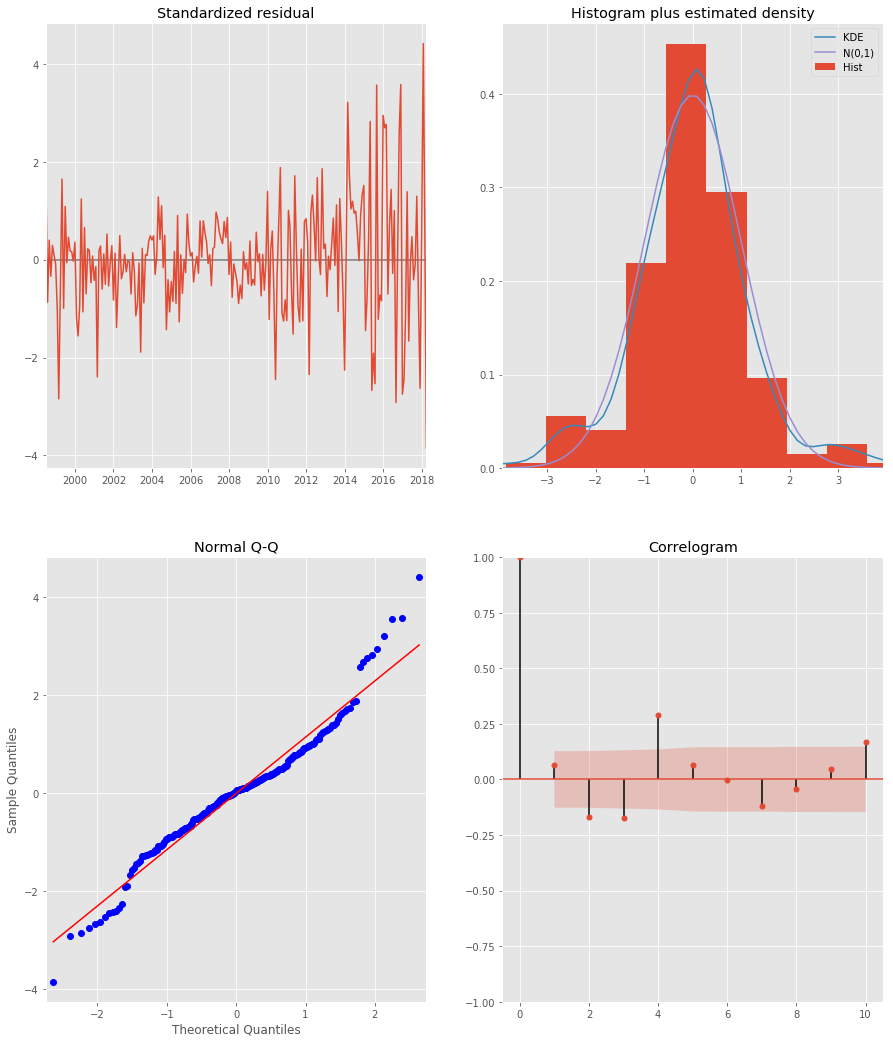

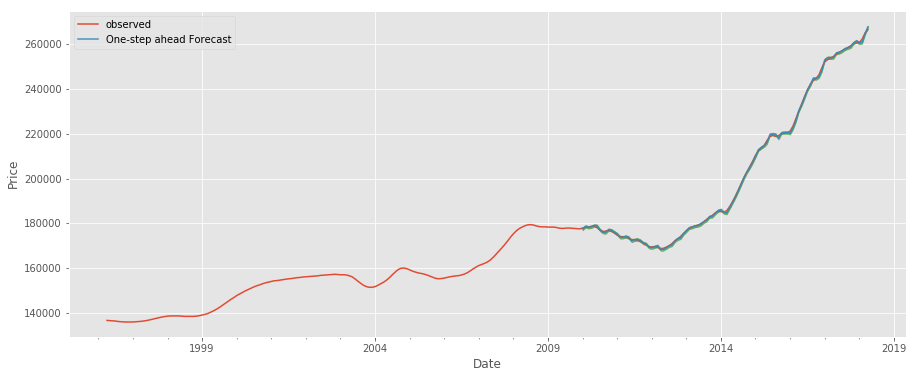

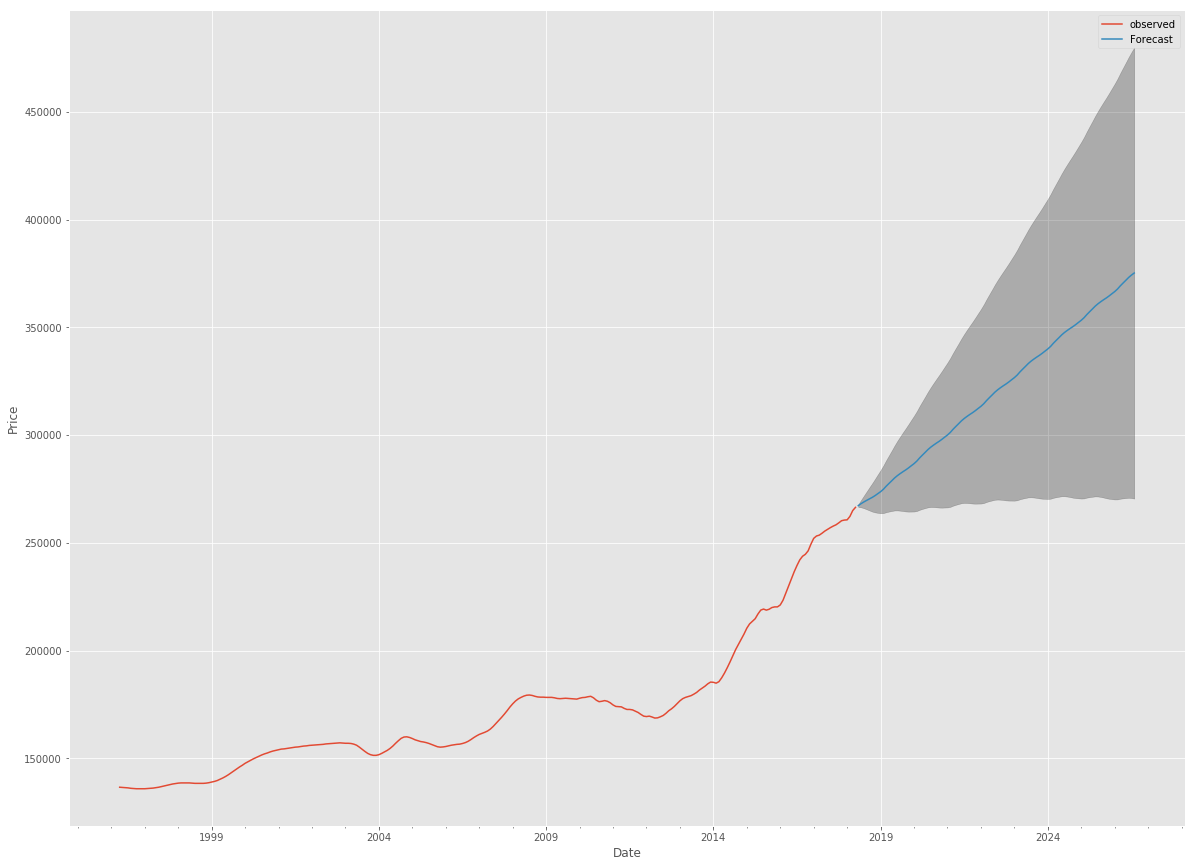

In [212]:
zip_arima_fit(df2['MeanValue'],(1,1,1),(0,1,1,12))

In [213]:
best_pdq(df3['MeanValue'])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7802.530942297311
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7291.092808661682
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6138.441113229768
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5852.346201879682
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =6111.666503403088
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =6086.942709913874
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5872.469572136473
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =7772.899147757378
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7582.946726050213
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =7640.84388337547
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =6215.756783263357
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =8986.186549638202
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7789.182408314235
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =7633.326852777317
ARIMA (0, 0, 1) x (1,

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8430      0.031     26.872      0.000       0.782       0.905
ma.L1          0.2150      0.014     14.854      0.000       0.187       0.243
ar.S.L12      -0.5108      0.047    -10.932      0.000      -0.602      -0.419
ma.S.L12       0.0040      0.013      0.298      0.766      -0.022       0.030
sigma2      7.083e+06   2.75e-09   2.57e+15      0.000    7.08e+06    7.08e+06


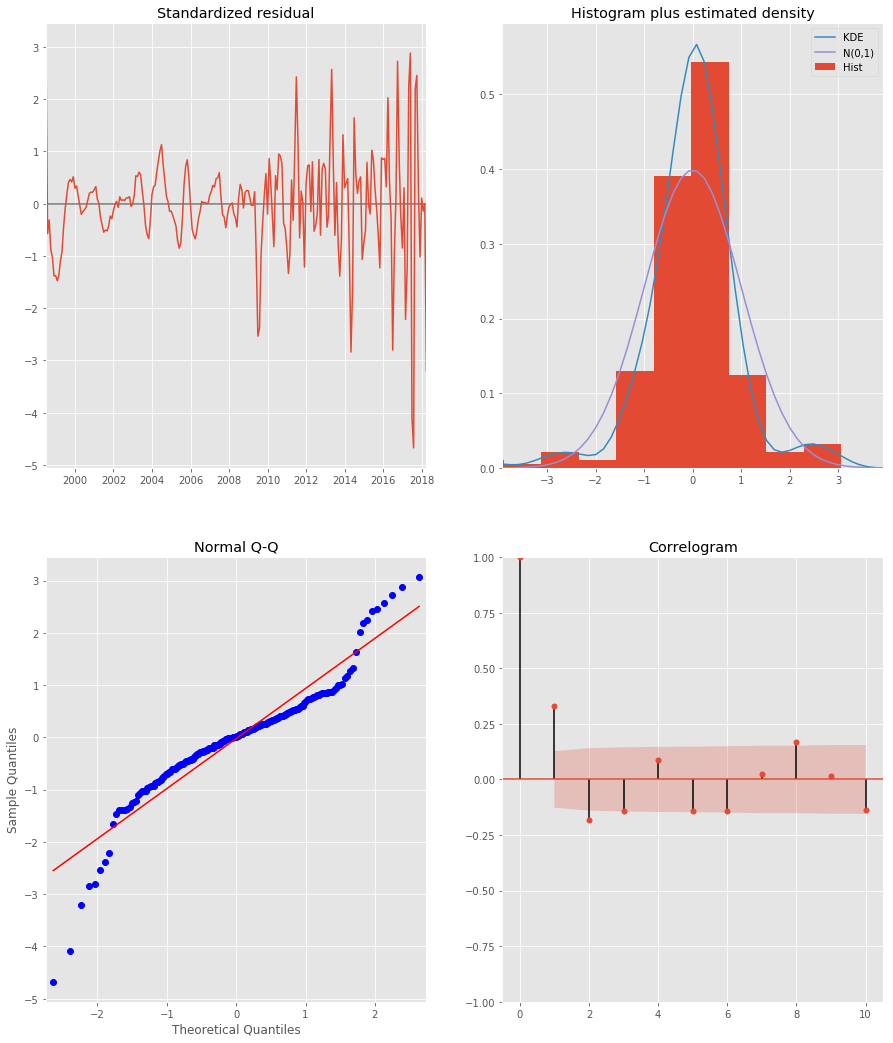

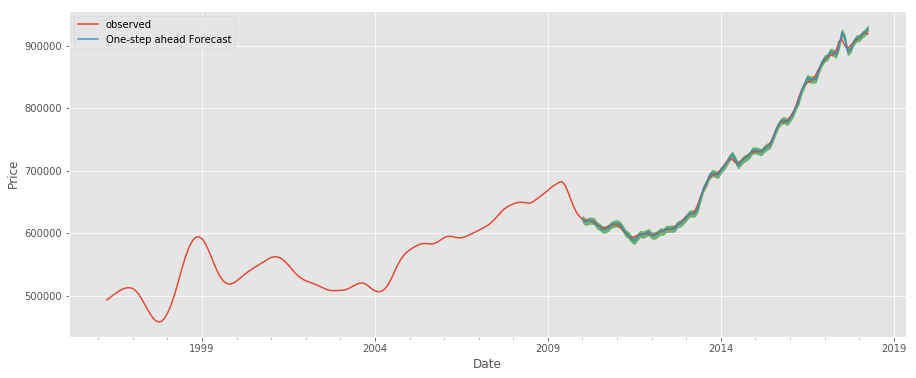

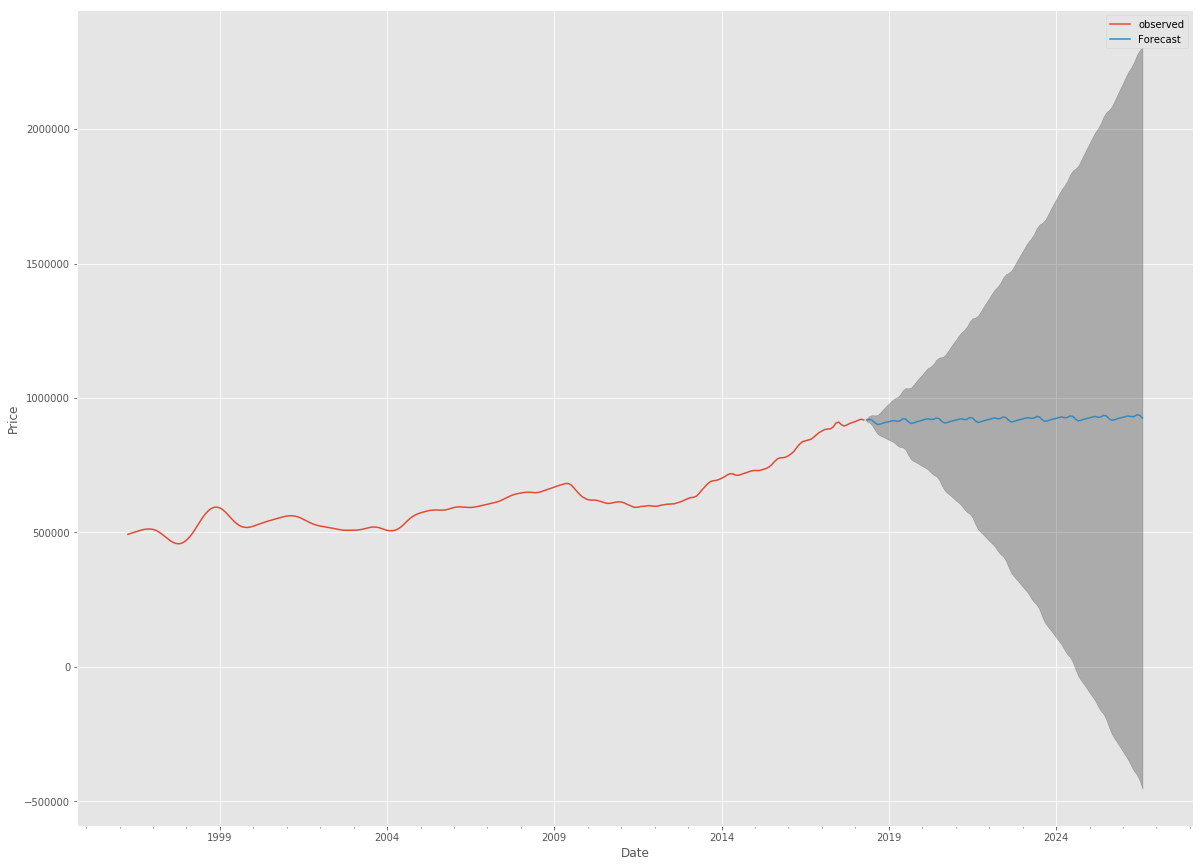

In [214]:
zip_arima_fit(df3['MeanValue'],(1,1,1),(1,1,1,12))
#remove p Value

In [215]:
best_pdq(df4['MeanValue'])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7439.375521253043
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6940.257877383479
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5633.6282435273615
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5378.471717381877
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5569.481203985469
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5550.482146789716
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5317.557194911515
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5298.548937510815
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7221.238895490095
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =7233.39351877499
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5648.838236409119
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =8075.138597833804
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7365.68369574518
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6829.414820595325
ARIMA (0, 0, 1) x (1,

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8942      0.026     35.052      0.000       0.844       0.944
ma.L1          0.6612      0.046     14.244      0.000       0.570       0.752
ar.S.L12      -0.1411      0.083     -1.709      0.087      -0.303       0.021
ma.S.L12      -0.2510      0.070     -3.561      0.000      -0.389      -0.113
sigma2      3.696e+05   1.96e+04     18.826      0.000    3.31e+05    4.08e+05


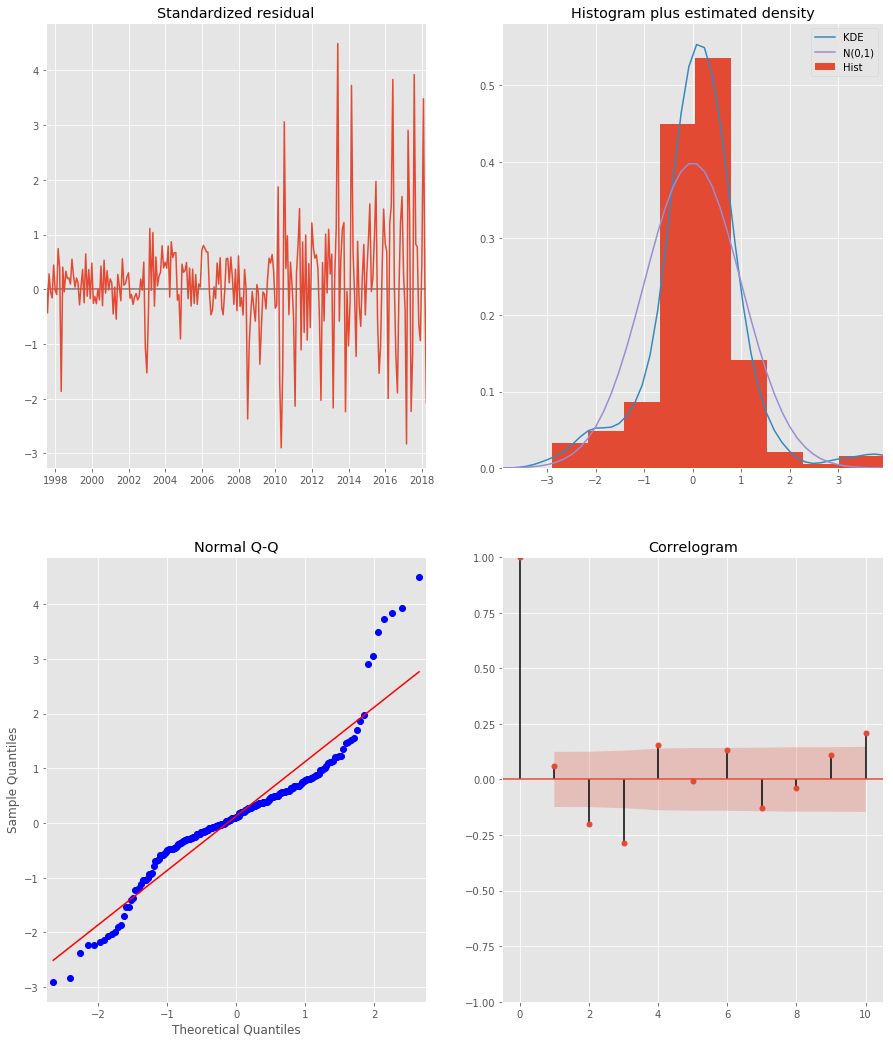

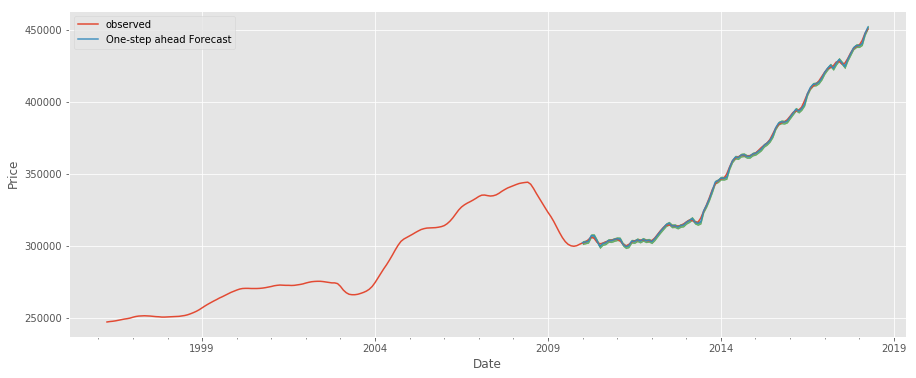

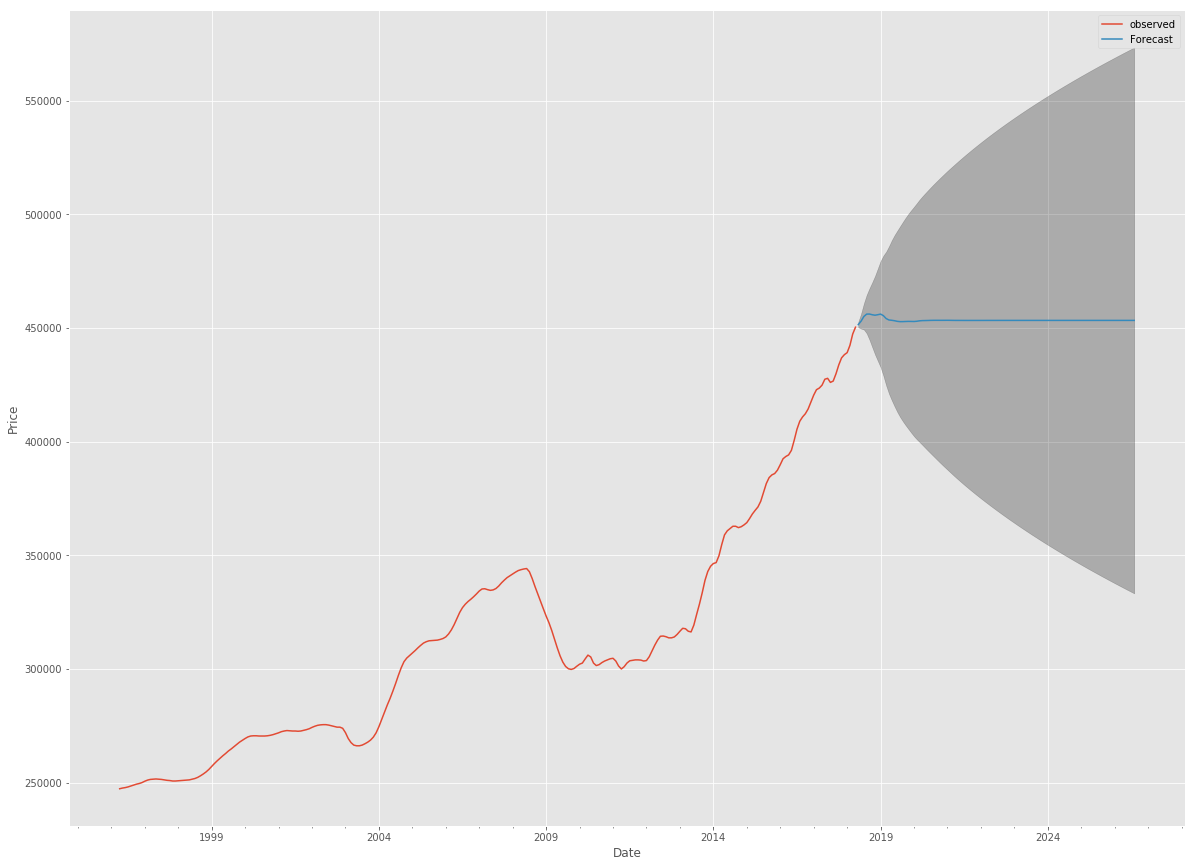

In [216]:
zip_arima_fit(df4['MeanValue'],(1,1,1),(1,0,1,12))
#remove p value

In [217]:
best_pdq(df5['MeanValue'])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7329.586837214289
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6832.32645093751
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5557.050701951304
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5296.014417079008
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5507.420415016579
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5481.581006125849
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5283.249873154423
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5264.0688245307265
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7111.869003228223
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6744.257118309858
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5381.564281567444
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4957.178453086501
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7237.169466385433
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =7147.627923135067
ARIMA (0, 0, 1) x (1

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8042      0.026     31.384      0.000       0.754       0.854
ma.L1          0.6742      0.030     22.646      0.000       0.616       0.733
ma.S.L12      -0.2900      0.029    -10.048      0.000      -0.347      -0.233
sigma2      4.935e+05   2.94e+04     16.761      0.000    4.36e+05    5.51e+05


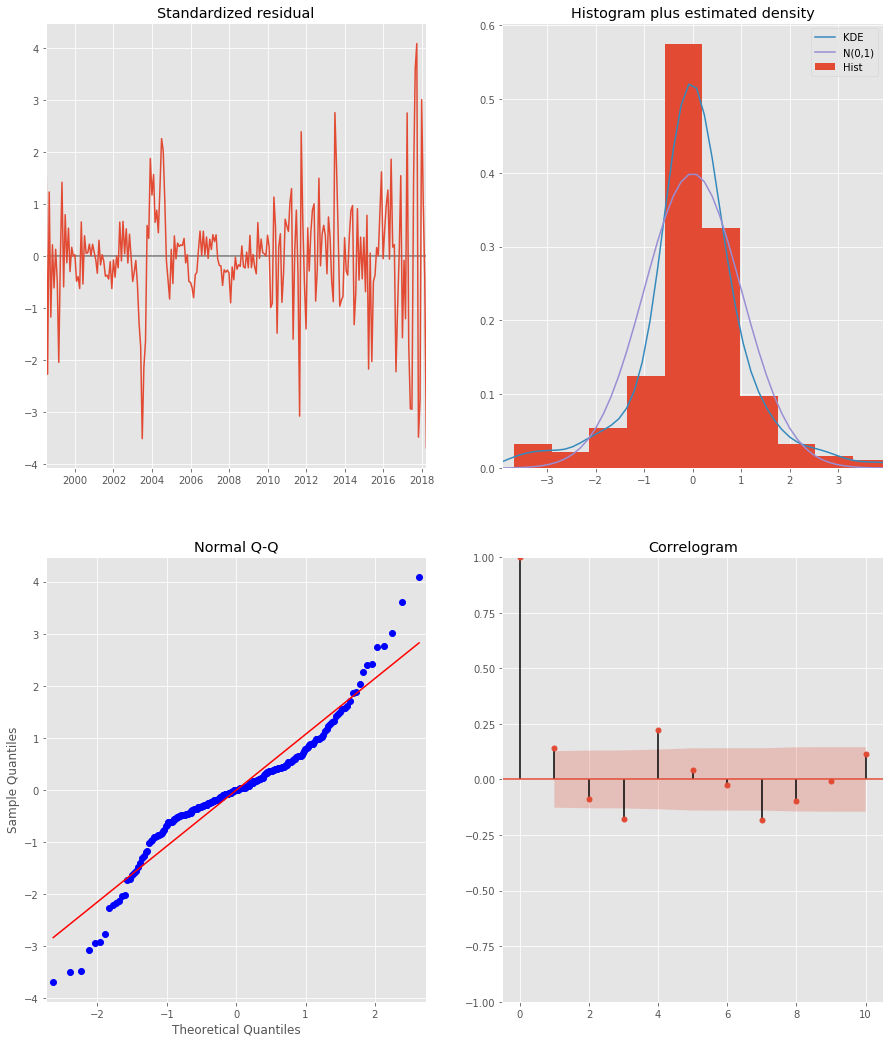

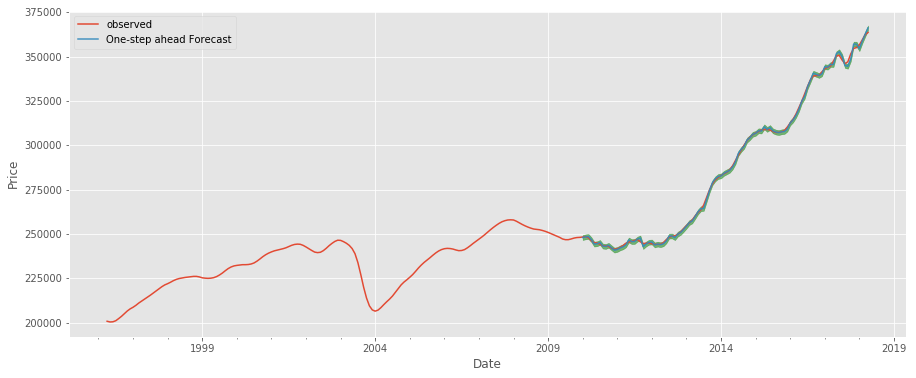

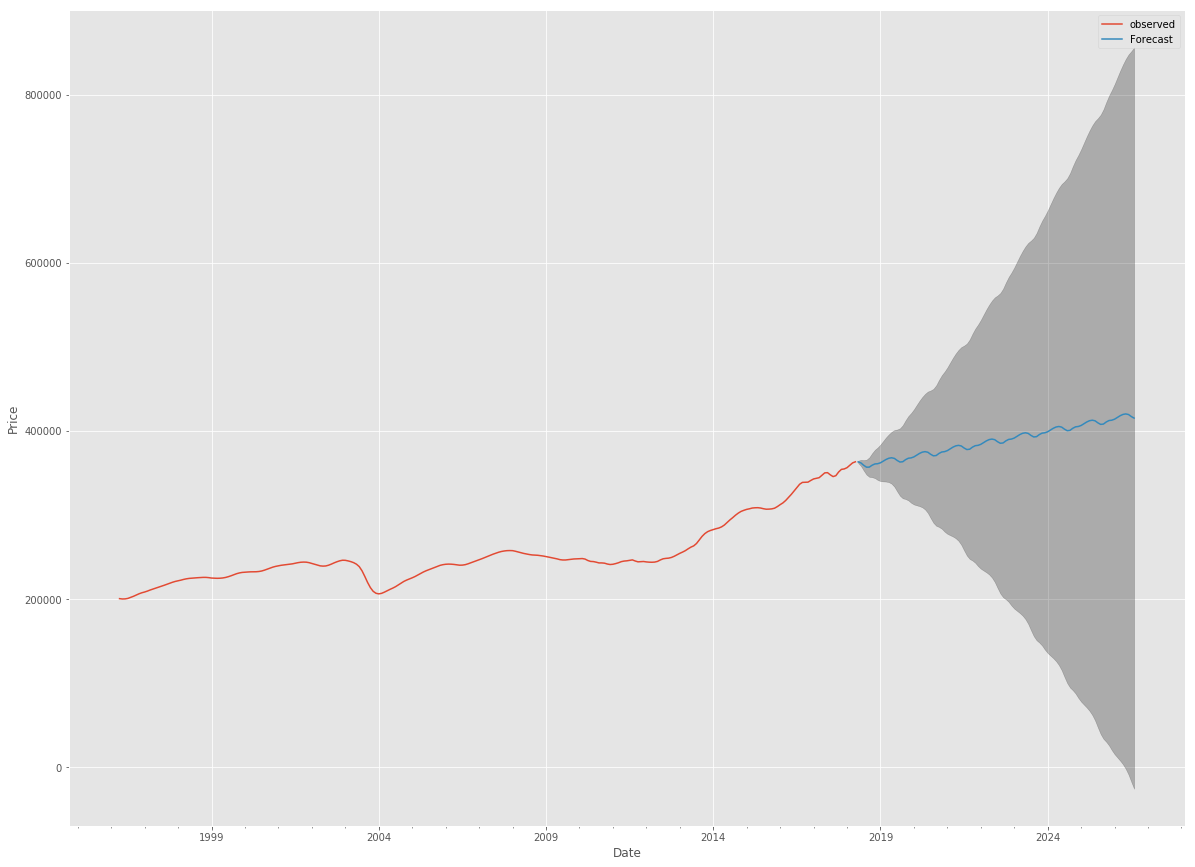

In [218]:
zip_arima_fit(df5['MeanValue'],(1,1,1),(0,1,1,12))
#This one looks good

# Expontential Trend (78728)

### Plot time series 

In [78]:
#new data frame with exponential zip
df2 = df.loc[df['RegionName'] == 78728]
df2.head()

,RegionName,MeanValue
Month,,
1996-04-01,78728,136600.0
1996-05-01,78728,136500.0
1996-06-01,78728,136400.0
1996-07-01,78728,136300.0
1996-08-01,78728,136100.0


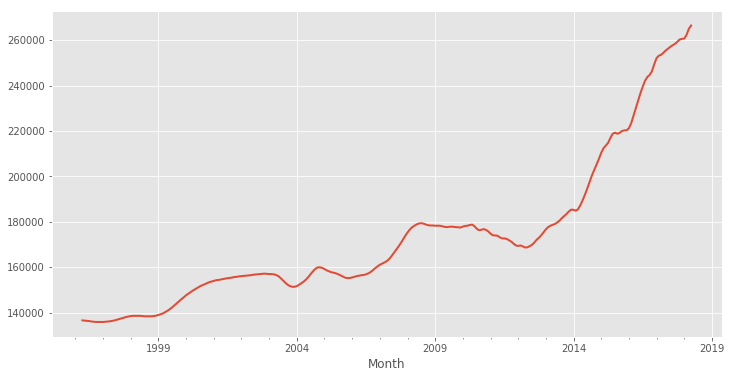

In [79]:
df2['MeanValue'].plot(figsize=(12,6), linewidth=2, fontsize=10);

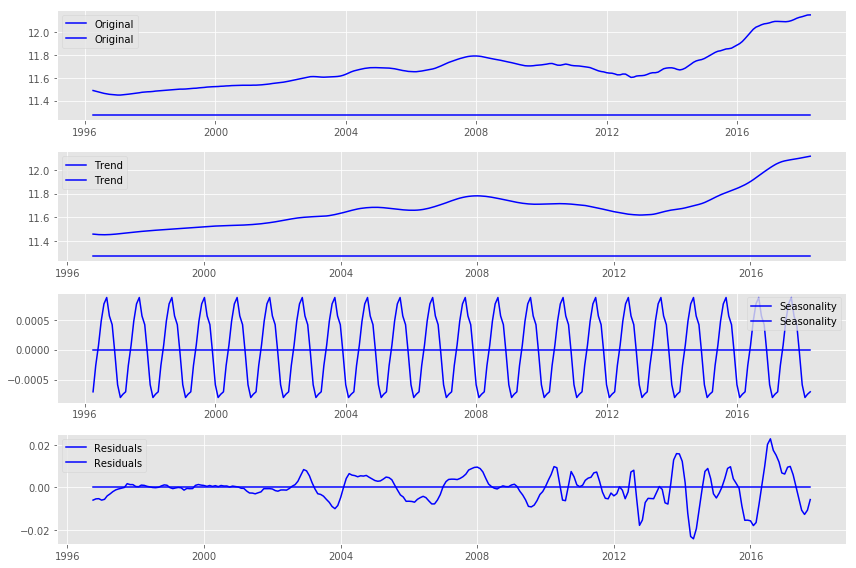

In [80]:
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(df1))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(df1), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

### Testing for Stationarity

In [81]:
def test_stationarity(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

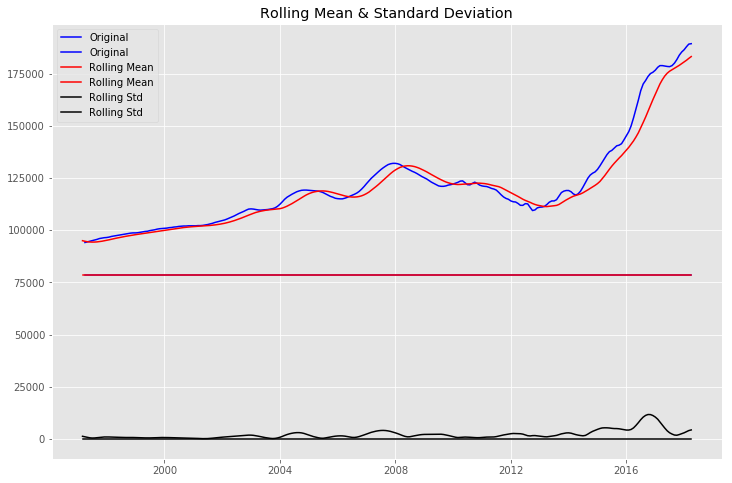

In [82]:
test_stationarity(df1, 12)

In [83]:
#Dicky Fuller test
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(df2['MeanValue'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                   1.025028
p-value                          0.994523
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


Since the test statistic greater than the p value the model is not stationary

### RemoveTrends

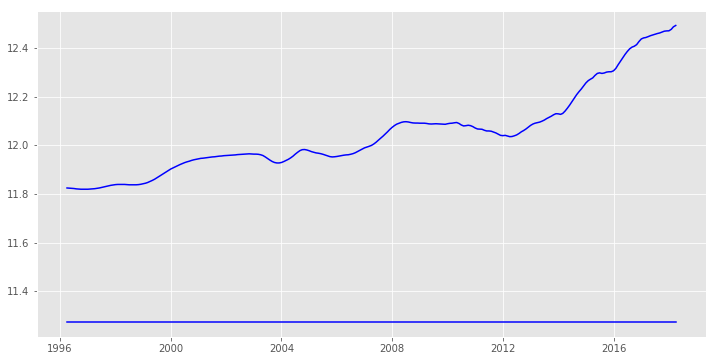

In [84]:
#log transform
ts_log = np.log(df2)
fig = plt.figure(figsize=(12,6))
plt.plot(ts_log, color='blue');

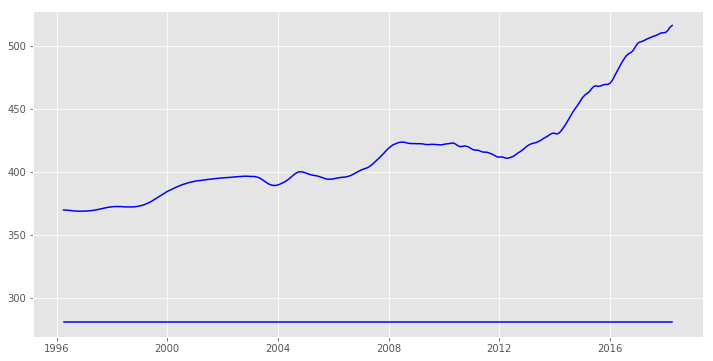

In [85]:
# Plot a square root transform
ts_sqrt = np.sqrt(df2)
fig = plt.figure(figsize=(12,6))
plt.plot(ts_sqrt, color='blue');

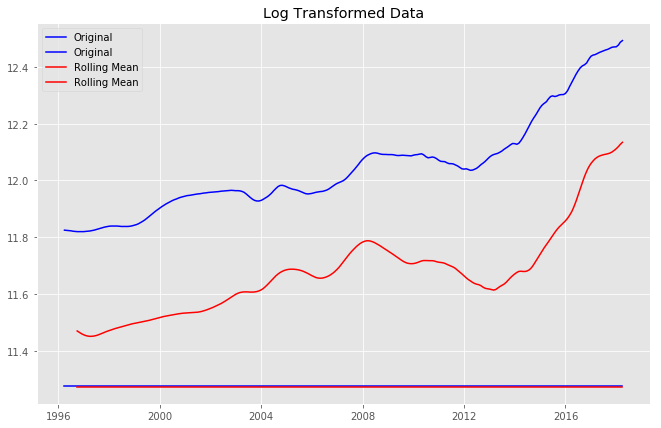

In [86]:
roll_mean = np.log(df1).rolling(window=7).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(np.log(df2), color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log Transformed Data')
plt.show(block=False)

In [97]:
#subtracting the rolling mean allows you to see the small points in between
# Subtract the moving average from the log transformed data
df_remove = np.log(df2) - roll_mean

# Print the first 10 rows
df_remove.head(10)

,RegionName,MeanValue
Month,,
1996-04-01,NaN,NaN
1996-05-01,NaN,NaN
1996-06-01,NaN,NaN
1996-07-01,NaN,NaN
1996-08-01,NaN,NaN
1996-09-01,NaN,NaN
1996-10-01,0.000051,0.350168
1996-11-01,0.000051,0.355239
1996-12-01,0.000051,0.359731


In [98]:
df_remove.dropna(inplace=True)

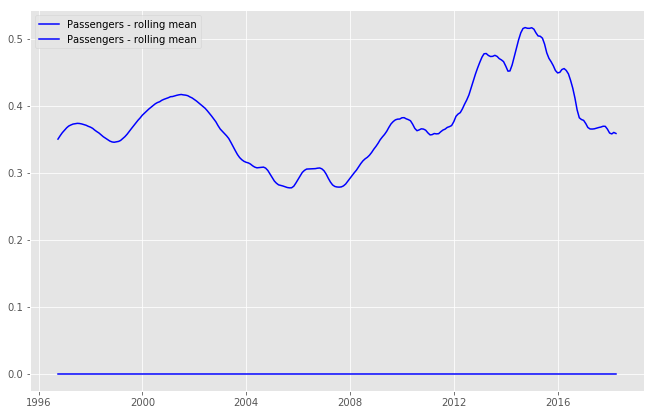

In [99]:
fig = plt.figure(figsize=(11,7))
plt.plot(df_remove, color='blue',label='Passengers - rolling mean')
plt.legend(loc='best')
plt.show(block=False)

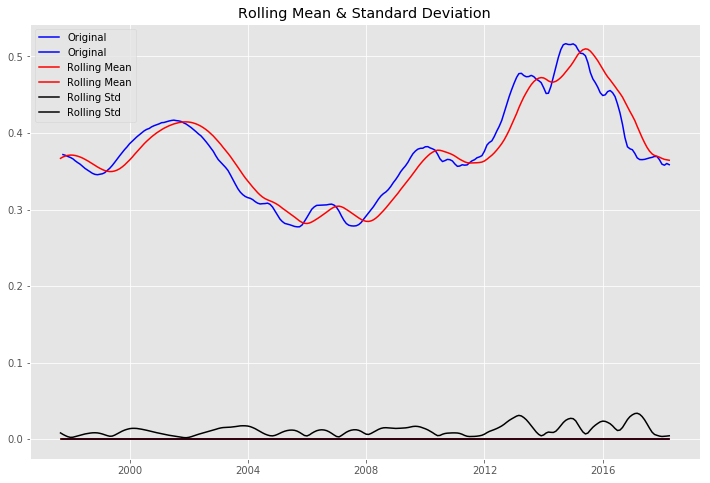

In [100]:
 test_stationarity(df_remove, 12)

In [101]:
#Dicky Fuller test
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(df_remove['MeanValue'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  -2.302123
p-value                          0.171284
#Lags Used                      16.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


Test Statistic is now less than the P value. We can reject the null and say that this model is now stationary.

### ARIMA Modeling

In [102]:
# widely used to understand and predict future values in stochastic processes
# a regression on past values takes place (AR part) and also that the error term is modeled as a linear combination of error terms of the recent past
# There is seasonality so we are using SARIMA

For evaluating the model, we shall use the AIC (Akaike Information Criterion) value, which is provided by ARIMA models fitted using statsmodels library. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To achieve this, perform following tasks:

Initialize an empty list to store results
Iterate through all the paramaters in pdq with parameters in seasonal pdq (nested loop ) to create a grid
Run SARIMAX from statsmodels for each iteration. Details can be found here. Set enforce_stationarity and enforce_invertibility to False
Get the results in each iteration with model.fit() and store the AIC values
Find the lowest AIC and select parameters for further analysis
NOTE:

Integrate exception handling with continue
An overview of Akaike Information Criterion can be viewed here

In [103]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [104]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.style.use('ggplot')
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_remove['MeanValue'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =234.61048856607925
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =191.2623395227212
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-889.9289179652492
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-847.8347676272522
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-892.999833023765
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-898.6732006144254
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-858.0930808824787
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-853.7849547028895
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =-114.00391926782781
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =72.80462746959412
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-1216.6769954475576
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-1011.3384225221337
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-1225.6780935421884
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-1010.9467105069042
ARIM

In [105]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 0, 0, 12)
aic          -2561.08
Name: 56, dtype: object

In [106]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_remove['MeanValue'], 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 0, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7788      0.029     26.635      0.000       0.722       0.836
ma.L1          0.7713      0.027     28.889      0.000       0.719       0.824
sigma2       2.58e-06   1.83e-07     14.082      0.000    2.22e-06    2.94e-06


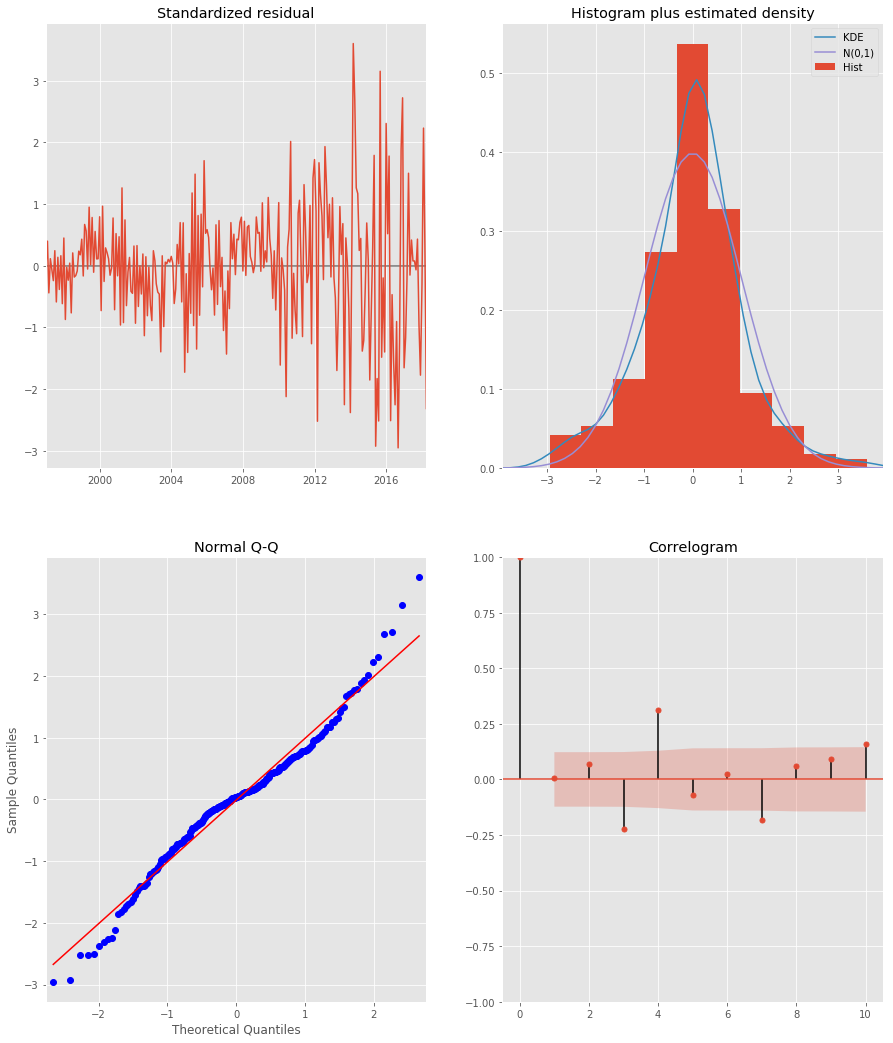

In [107]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [108]:
pred = output.get_prediction(start=pd.to_datetime('2010-10-01'), dynamic=False)
pred_conf = pred.conf_int()

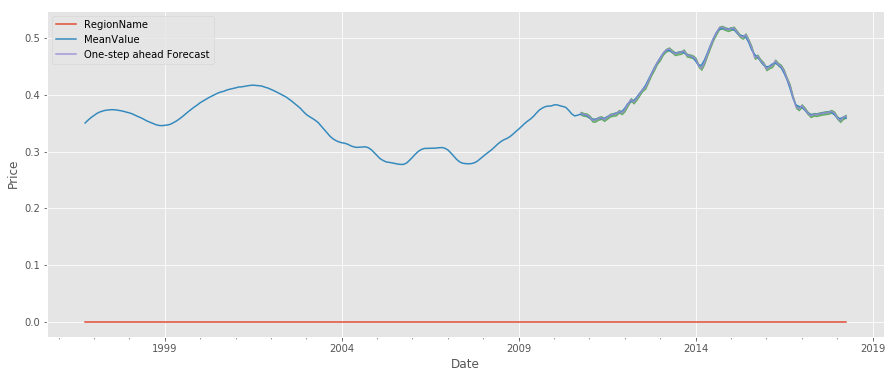

In [109]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_remove['1996':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [110]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()


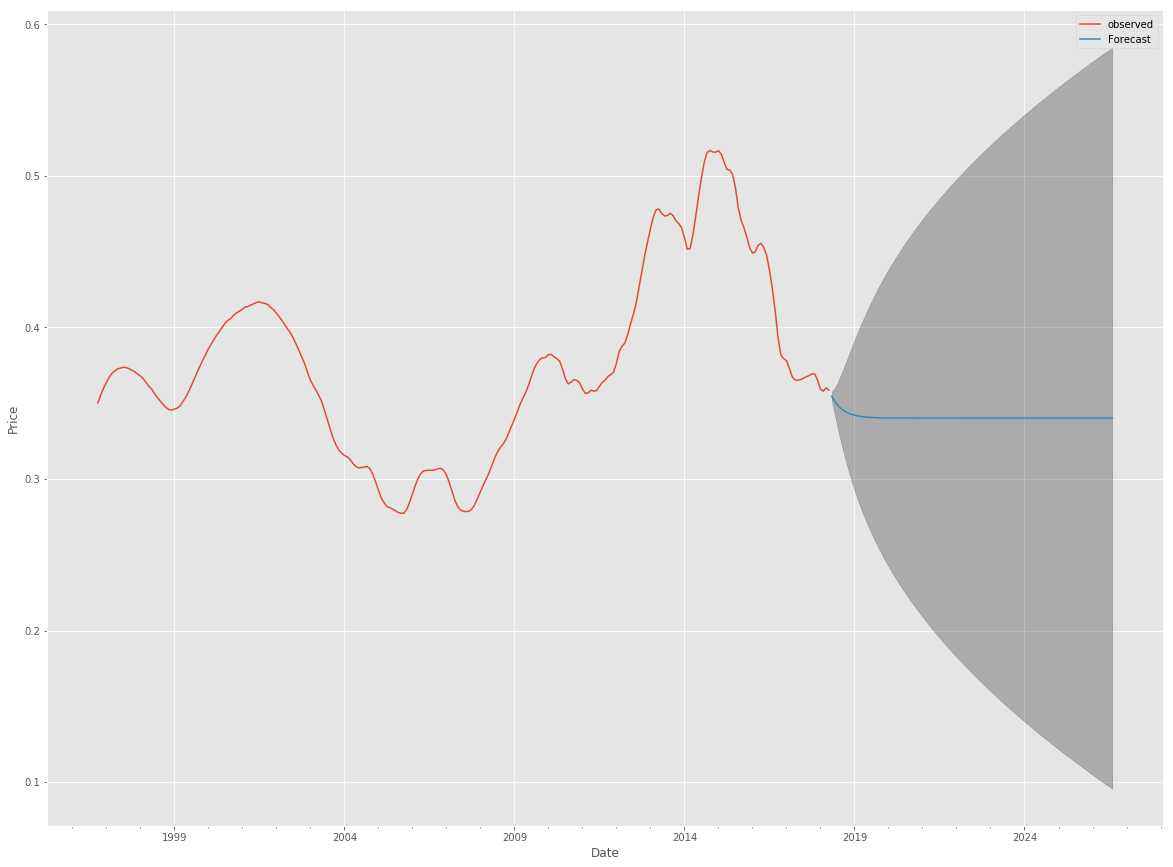

In [111]:
ax = df_remove['MeanValue'].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

### Run this through the other zipcodes and also use the sarimax lab and Magnawhale project to scope this down and make it correct. 

# Interpreting Results

If I had more time I would have done stationarity tests for all of the models and detrended where necessary